In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


#model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from xgboost import  XGBClassifier
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# stepwise
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# perform
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# under-sample
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

# statics
import scipy.stats as st
import torch

import random 

random.seed(10)

In [2]:
df = pd.read_csv("./Final_df.csv")
df.head(5)

,Unnamed: 0,limit_bal,sex,age,pay_Sep,pay_Aug,pay_Jul,pay_Jun,pay_May,pay_Apr,...,pay_amt_May,pay_amt_Apr,IsDefaulter,Payement_Value,Dues,education_graduate school,education_high school,education_university,marriage_married,marriage_single
0,0,20000,0,24,2,2,-1,-1,-2,-2,...,0,0,1,-2,3913,0,0,1,1,0
1,1,120000,0,26,-1,2,0,0,0,2,...,0,2000,1,3,10352,0,0,1,0,1
2,2,90000,0,34,0,0,0,0,0,0,...,1000,5000,0,0,76608,0,0,1,0,1
3,3,50000,0,37,0,0,0,0,0,0,...,1069,1000,0,0,174713,0,0,1,1,0
4,4,50000,1,57,-1,0,-1,0,0,0,...,689,679,0,-2,44620,0,0,1,1,0


In [3]:
X = df.drop(['IsDefaulter','Payement_Value','Dues','Unnamed: 0'],axis=1)
y = df['IsDefaulter']

In [4]:
X.iloc[:,21:26]=X.iloc[:,21:26].astype('category')
X.iloc[:,3:9]=X.iloc[:,3:9].astype('category')
X.iloc[:,1]=X.iloc[:,1].astype('category')

In [5]:
num_d = X.select_dtypes(exclude=['category'])

In [6]:
scaler = StandardScaler()
X[num_d.columns] = scaler.fit_transform(num_d)

## Grid Search 

In [7]:
#change the resampling strategies for oversampling and undersampling techniques
def Sampling_GridSearch(strategy1,strategy2,X_train,y_train):
    #resample
    X_resample, y_resample = SMOTE(sampling_strategy=strategy1).fit_resample(X_train, y_train)
    X_resample, y_resample = RandomUnderSampler(random_state=0,sampling_strategy=strategy2).fit_resample(X_resample,y_resample)
    #drop the NA
    na_train=X_resample.loc[X_resample.isnull().any(axis=1)].index
    X_resample=X_resample.drop(na_train)
    y_resample=y_resample.drop(na_train)
    return X_resample,y_resample

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [10]:
#original data's ratio of defualt instances to non-default intances
count = y_train.describe()[0]
mean = y_train.describe()[1]
num_1 = count*mean
num_0 = count-num_1
num_1/num_0# the sampling strategy can not be lower than this

0.2840168646991184

In [24]:
s1 = np.arange(0.29,0.99,0.01)
s2 = np.arange(0.30,1.0,0.01)
test_accuracy_logit = np.zeros((s1.shape[0],s2.shape[0]))
test_precision_score_logit = np.zeros((s1.shape[0],s2.shape[0]))
test_recall_score_logit = np.zeros((s1.shape[0],s2.shape[0]))
test_f1_score_logit = np.zeros((s1.shape[0],s2.shape[0]))
test_roc_score_logit =np.zeros((s1.shape[0],s2.shape[0]))
i=0
j=0

for i in np.arange(70):
    for j in np.arange(70):
        
        strategy1 = s1[i]
        if s2[j] > s1[i]:
            strategy2 = s2[j]
        else:
            continue
                
        X_resample, y_resample = Sampling_GridSearch(strategy1,strategy2,X_train,y_train)
        logreg_sk =  LogisticRegression(solver='newton-cg' ,class_weight='balanced') 
        logreg_sk.fit(X_resample,y_resample)
        logit_test_class_preds = logreg_sk.predict(X_test)
        test_accuracy_logit[i,j] = accuracy_score(logit_test_class_preds,y_test)
        test_precision_score_logit[i,j] = precision_score(logit_test_class_preds,y_test)
        test_recall_score_logit[i,j] = recall_score(logit_test_class_preds,y_test)
        test_f1_score_logit[i,j] = f1_score(logit_test_class_preds,y_test)
        test_roc_score_logit[i,j] = roc_auc_score(logit_test_class_preds,y_test)


In [25]:
# store the model performance
import csv

with open('test_accuracy_lr.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_accuracy_logit)
with open('test_precision_score_lr.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_precision_score_logit)
with open('test_recall_score_lr.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_recall_score_logit)
with open('test_f1_score_lr.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_f1_score_logit)
with open('test_roc_score_lr.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_roc_score_logit)

In [11]:
test_accuracy_logit = pd.read_csv('test_accuracy_lr.csv', sep=' ', header=None).values
test_precision_score_logit= pd.read_csv('test_precision_score_lr.csv', sep=' ', header=None).values
test_recall_score_logit= pd.read_csv('test_recall_score_lr.csv', sep=' ', header=None).values
test_f1_score_logit= pd.read_csv('test_f1_score_lr.csv', sep=' ', header=None).values
test_roc_score_logit= pd.read_csv('test_roc_score_lr.csv', sep=' ', header=None).values

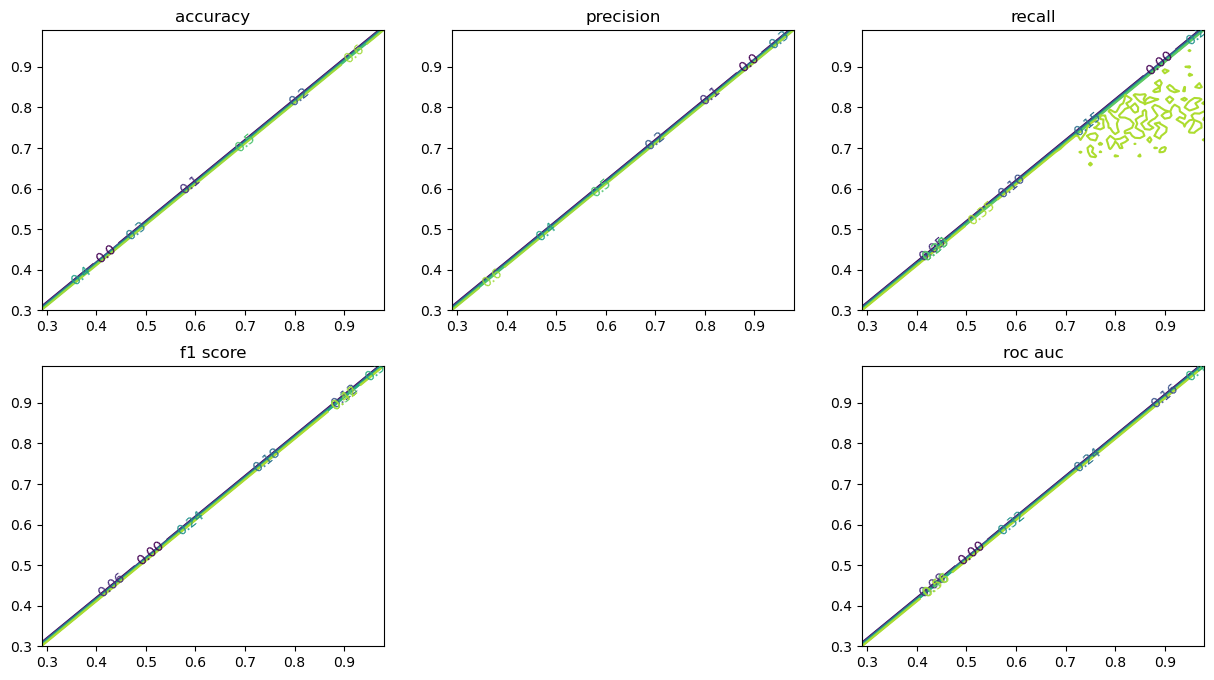

In [12]:
# grid search the resampling strategies for logistic regression
S1, S2 = np.meshgrid(s1, s2)

fig, axs = plt.subplots(2,3,figsize=(15, 8))
p_acc = axs[0,0].contour(S1, S2, test_accuracy_logit)
p_pre = axs[0,1].contour(S1, S2, test_precision_score_logit)
p_recall = axs[0,2].contour(S1, S2, test_recall_score_logit)
p_f1 = axs[1,0].contour(S1, S2, test_f1_score_logit)
p_roc = axs[1,2].contour(S1, S2, test_roc_score_logit)

axs[1][1].set_visible(False)
axs[0,0].clabel(p_acc, inline=True, fontsize=10)
axs[0,1].clabel(p_pre, inline=True, fontsize=10)
axs[0,2].clabel(p_recall, inline=True, fontsize=10)
axs[1,0].clabel(p_f1, inline=True, fontsize=10)
axs[1,2].clabel(p_roc, inline=True, fontsize=10)

axs[0,0].title.set_text('accuracy')
axs[0,1].title.set_text('precision')
axs[0,2].title.set_text('recall')
axs[1,0].title.set_text('f1 score')
axs[1,2].title.set_text('roc auc')
plt.show()

In [8]:
#random forest grid search
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
s1 = np.arange(0.29,0.99,0.01)
s2 = np.arange(0.30,1.0,0.01)
test_accuracy_rf = np.zeros((s1.shape[0],s2.shape[0]))
test_precision_score_rf = np.zeros((s1.shape[0],s2.shape[0]))
test_recall_score_rf = np.zeros((s1.shape[0],s2.shape[0]))
test_f1_score_rf = np.zeros((s1.shape[0],s2.shape[0]))
test_roc_score_rf =np.zeros((s1.shape[0],s2.shape[0]))
i=0
j=0

for i in np.arange(70):
    for j in np.arange(70):
        
        strategy1 = s1[i]
        if s2[j] > s1[i]:
            strategy2 = s2[j]
        else:
            continue
                
        X_resample, y_resample = Sampling_GridSearch(strategy1,strategy2,X_train,y_train)
        param_grid = {'n_estimators': [100,150,200], 'max_depth': [10,20,30]}
        grid_rf_clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
        grid_rf_clf.fit(X_resample, y_resample)
        optimal_rf_clf = grid_rf_clf.best_estimator_
        rf_test_class_preds = optimal_rf_clf.predict(X_test)
        
        test_accuracy_rf[i,j] = accuracy_score(rf_test_class_preds,y_test)
        test_precision_score_rf[i,j] = precision_score(rf_test_class_preds,y_test)
        test_recall_score_rf[i,j] = recall_score(rf_test_class_preds,y_test)
        test_f1_score_rf[i,j] = f1_score(rf_test_class_preds,y_test)
        test_roc_score_rf[i,j] = roc_auc_score(rf_test_class_preds,y_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates

In [10]:
#store the model performance of Random Forest
import csv

with open('test_accuracy_rf.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_accuracy_rf)
with open('test_precision_score_rf.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_precision_score_rf)
with open('test_recall_score_rf.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_recall_score_rf)
with open('test_f1_score_rf.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_f1_score_rf)
with open('test_roc_score_rf.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_roc_score_rf)

In [2]:
#read the performance data
test_accuracy_rf = pd.read_csv('test_accuracy_rf.csv', sep=' ', header=None).values
test_precision_score_rf= pd.read_csv('test_precision_score_rf.csv', sep=' ', header=None).values
test_recall_score_rf= pd.read_csv('test_recall_score_rf.csv', sep=' ', header=None).values
test_f1_score_rf= pd.read_csv('test_f1_score_rf.csv', sep=' ', header=None).values
test_roc_score_rf= pd.read_csv('test_roc_score_rf.csv', sep=' ', header=None).values

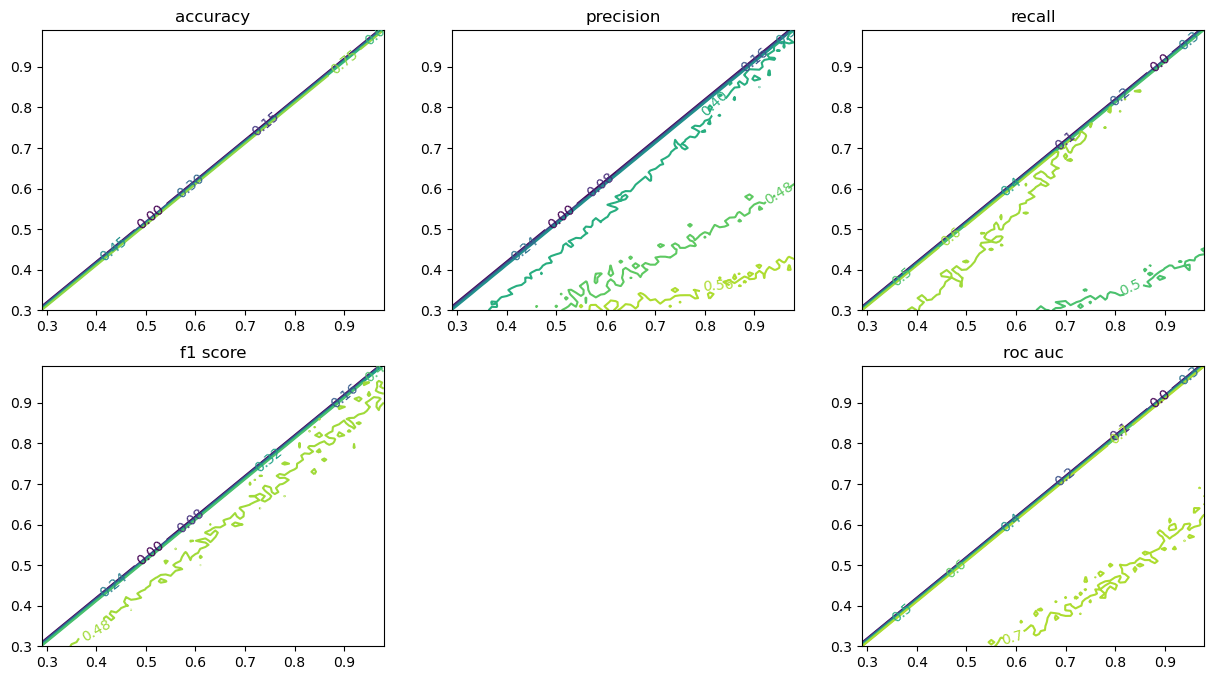

In [6]:
s1 = np.arange(0.29,0.99,0.01)
s2 = np.arange(0.30,1.0,0.01)

S1, S2 = np.meshgrid(s1, s2)

###TOOOOO CLOSE!!!
fig, axs = plt.subplots(2,3,figsize=(15, 8))
p_acc = axs[0,0].contour(S1, S2, test_accuracy_rf)
p_pre = axs[0,1].contour(S1, S2, test_precision_score_rf)
p_recall = axs[0,2].contour(S1, S2, test_recall_score_rf)
p_f1 = axs[1,0].contour(S1, S2, test_f1_score_rf)
p_roc = axs[1,2].contour(S1, S2, test_roc_score_rf)

axs[1][1].set_visible(False)
axs[0,0].clabel(p_acc, inline=True, fontsize=10)
axs[0,1].clabel(p_pre, inline=True, fontsize=10)
axs[0,2].clabel(p_recall, inline=True, fontsize=10)
axs[1,0].clabel(p_f1, inline=True, fontsize=10)
axs[1,2].clabel(p_roc, inline=True, fontsize=10)

axs[0,0].title.set_text('accuracy')
axs[0,1].title.set_text('precision')
axs[0,2].title.set_text('recall')
axs[1,0].title.set_text('f1 score')
axs[1,2].title.set_text('roc auc')

In [8]:
#Gride search for resampling startegies in XGBoosting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
xgb_train=X_train.copy()
xgb_train.iloc[:,21:26]=xgb_train.iloc[:,21:26].astype('int64')
xgb_train.iloc[:,3:9]=xgb_train.iloc[:,3:9].astype('int64')
xgb_train.iloc[:,1]=xgb_train.iloc[:,1].astype('int64')
xgb_test = X_test.copy()
xgb_test.iloc[:,21:26]=xgb_test.iloc[:,21:26].astype('int64')
xgb_test.iloc[:,3:9]=xgb_test.iloc[:,3:9].astype('int64')
xgb_test.iloc[:,1]=xgb_test.iloc[:,1].astype('int64')

In [ ]:
s1 = np.arange(0.29,0.99,0.01)
s2 = np.arange(0.30,1.0,0.01)
test_accuracy_xgb = np.zeros((s1.shape[0],s2.shape[0]))
test_precision_score_xgb = np.zeros((s1.shape[0],s2.shape[0]))
test_recall_score_xgb = np.zeros((s1.shape[0],s2.shape[0]))
test_f1_score_xgb = np.zeros((s1.shape[0],s2.shape[0]))
test_roc_score_xgb =np.zeros((s1.shape[0],s2.shape[0]))
i=0
j=0

for i in np.arange(70):
    for j in np.arange(70):
        
        strategy1 = s1[i]
        if s2[j] > s1[i]:
            strategy2 = s2[j]
        else:
            continue
                
        X_resample, y_resample = Sampling_GridSearch(strategy1,strategy2,xgb_train,y_train)
        param_test1 = {
         'max_depth':range(3,10,2),
         'min_child_weight':range(3,10,1)
        }
        gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=140, max_depth=5,
         min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
         objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,class_weight='balanced'), 
         param_grid = param_test1, scoring='recall',n_jobs=-1, cv=3, verbose = 2)
        gsearch1.fit(X_resample, y_resample)
        optimal_xgb = gsearch1.best_estimator_
        xgb_test_class_preds = optimal_xgb.predict(xgb_test)
        
        test_accuracy_xgb[i,j] = accuracy_score(xgb_test_class_preds,y_test)
        test_precision_score_xgb[i,j] = precision_score(xgb_test_class_preds,y_test)
        test_recall_score_xgb[i,j] = recall_score(xgb_test_class_preds,y_test)
        test_f1_score_xgb[i,j] = f1_score(xgb_test_class_preds,y_test)
        test_roc_score_xgb[i,j] = roc_auc_score(xgb_test_class_preds,y_test)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [ ]:
#store model performance of XGBoosting
import csv

with open('test_accuracy_xgb.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_accuracy_xgb)
with open('test_precision_score_xgb.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_precision_score_xgb)
with open('test_recall_score_xgb.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_recall_score_xgb)
with open('test_f1_score_xgb.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_f1_score_xgb)
with open('test_roc_score_xgb.csv', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_roc_score_xgb)

In [9]:
# read the performance data
test_accuracy_xgb = pd.read_csv('test_accuracy_xgb.csv', sep=' ', header=None).values
test_precision_score_xgb= pd.read_csv('test_precision_score_xgb.csv', sep=' ', header=None).values
test_recall_score_xgb= pd.read_csv('test_recall_score_xgb.csv', sep=' ', header=None).values
test_f1_score_xgb= pd.read_csv('test_f1_score_xgb.csv', sep=' ', header=None).values
test_roc_score_xgb= pd.read_csv('test_roc_score_xgb.csv', sep=' ', header=None).values

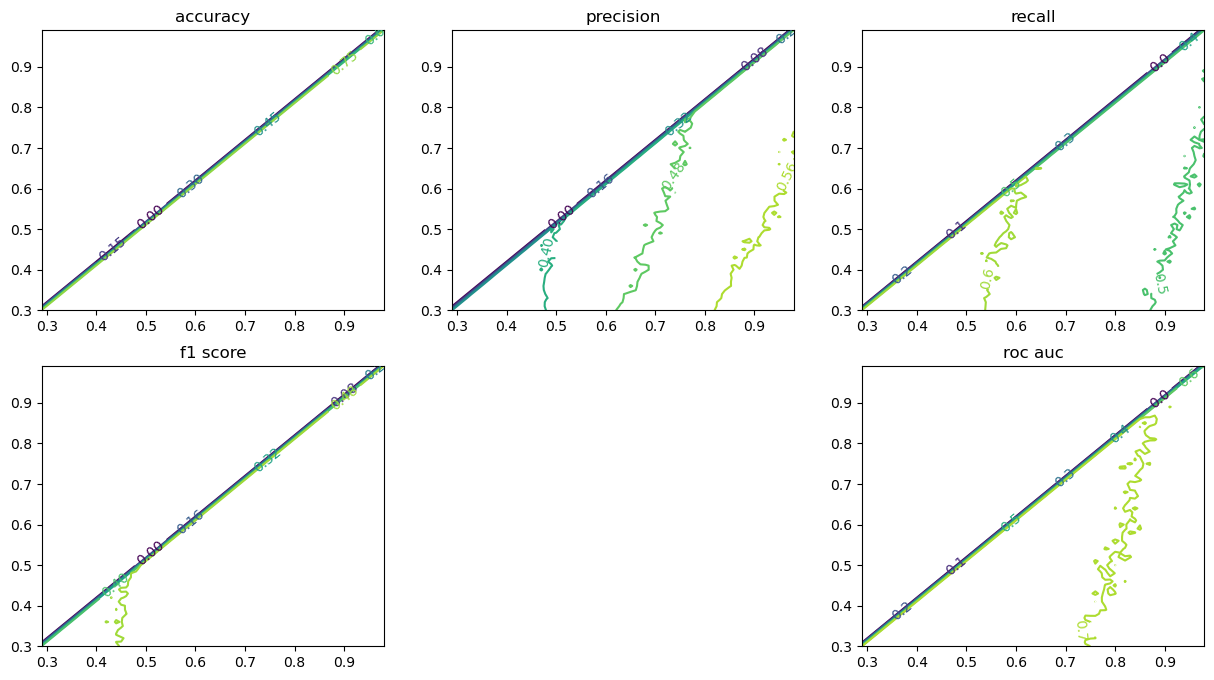

In [10]:
s1 = np.arange(0.29,0.99,0.01)
s2 = np.arange(0.30,1.0,0.01)

S1, S2 = np.meshgrid(s1, s2)

###TOOOOO CLOSE!!!
fig, axs = plt.subplots(2,3,figsize=(15, 8))
p_acc = axs[0,0].contour(S1, S2, test_accuracy_xgb)
p_pre = axs[0,1].contour(S1, S2, test_precision_score_xgb)
p_recall = axs[0,2].contour(S1, S2, test_recall_score_xgb)
p_f1 = axs[1,0].contour(S1, S2, test_f1_score_xgb)
p_roc = axs[1,2].contour(S1, S2, test_roc_score_xgb)
axs[1][1].set_visible(False)
axs[0,0].clabel(p_acc, inline=True, fontsize=10)
axs[0,1].clabel(p_pre, inline=True, fontsize=10)
axs[0,2].clabel(p_recall, inline=True, fontsize=10)
axs[1,0].clabel(p_f1, inline=True, fontsize=10)
axs[1,2].clabel(p_roc, inline=True, fontsize=10)

axs[0,0].title.set_text('accuracy')
axs[0,1].title.set_text('precision')
axs[0,2].title.set_text('recall')
axs[1,0].title.set_text('f1 score')
axs[1,2].title.set_text('roc auc')
plt.show()